In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib


In [4]:

df = pd.read_excel("Merged.xlsx")
df.head()

,Day,BPM,SPO2,BodyTemp
0,1,72.00,98.20,36.30
1,1,71.88,98.01,36.38
2,1,71.95,98.18,36.42
3,1,72.11,97.98,36.15
4,1,71.76,98.35,36.28


In [5]:
print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
df.describe()


Shape: (856, 4)

Missing Values:
 Day         0
BPM         0
SPO2        0
BodyTemp    0
dtype: int64

Data Types:
 Day           int64
BPM         float64
SPO2        float64
BodyTemp    float64
dtype: object


,Day,BPM,SPO2,BodyTemp
count,856.000000,856.000000,856.000000,856.000000
mean,14.492991,72.241916,98.068353,36.289965
std,8.138707,1.573581,0.573352,0.247347
min,1.000000,69.630000,97.400000,35.690000
25%,7.000000,70.990000,97.530000,36.090000
50%,14.000000,72.200000,97.985000,36.230000
75%,22.000000,73.480000,98.770000,36.500000
max,28.000000,74.960000,98.990000,36.790000


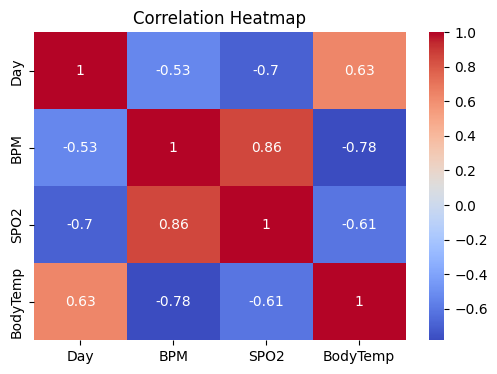

In [6]:
# Quick correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [7]:
# Rolling features
df['BodyTemp_RollMean'] = df['BodyTemp'].rolling(window=5, min_periods=1).mean()
df['BPM_RollMean'] = df['BPM'].rolling(window=5, min_periods=1).mean()

# Amplitude
df['Temp_Amplitude'] = df['BodyTemp'].rolling(window=5, min_periods=1).apply(lambda x: x.max() - x.min(), raw=True)

# Drop NA from rolling if any
df.dropna(inplace=True)

# Select features
features = ['BodyTemp', 'BPM', 'SPO2', 'BodyTemp_RollMean', 'BPM_RollMean', 'Temp_Amplitude']
X = df[features]


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# Save model
joblib.dump(kmeans, "kmeans_model.pkl")


['kmeans_model.pkl']

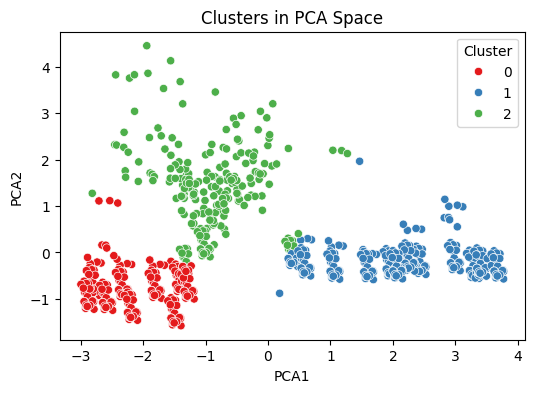

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set1')
plt.title("Clusters in PCA Space")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


In [11]:
cluster_to_phase = {
    0: 'Follicular',
    1: 'Ovulatory',
    2: 'Luteal'
}

joblib.dump(cluster_to_phase, "fertility_cluster_mapper.pkl")


['fertility_cluster_mapper.pkl']

In [13]:
# Load your cluster-to-phase mapping (if not already in memory)
cluster_to_phase = joblib.load("fertility_cluster_mapper.pkl")

# Map clusters to phase names
df['Phase_Label'] = df['Cluster'].map(cluster_to_phase)

# Verify the mapping
df[['Cluster', 'Phase_Label']].drop_duplicates()


,Cluster,Phase_Label
0,1,Ovulatory
3,2,Luteal
158,0,Follicular


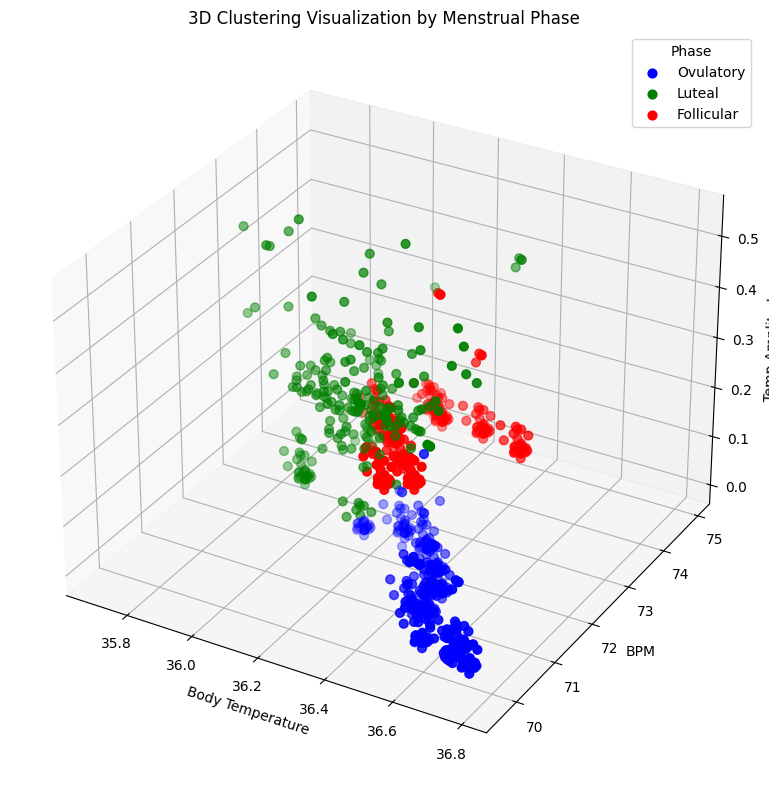

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define unique phases and their colors
phases = df['Phase_Label'].unique()
colors = ['blue', 'green', 'red']
color_map = dict(zip(phases, colors))

# Plot each phase separately
for phase in phases:
    subset = df[df['Phase_Label'] == phase]
    ax.scatter(
        subset['BodyTemp'],
        subset['BPM'],
        subset['Temp_Amplitude'],
        label=phase,
        c=color_map[phase],
        s=40
    )

# Set axis labels
ax.set_xlabel('Body Temperature')
ax.set_ylabel('BPM')
ax.set_zlabel('Temp Amplitude')
ax.set_title('3D Clustering Visualization by Menstrual Phase')
ax.legend(title='Phase')
plt.tight_layout()
plt.show()


## testing 

In [22]:
import joblib

# Load saved artifacts
scaler = joblib.load("scaler.pkl")
kmeans = joblib.load("kmeans_model.pkl")
cluster_to_phase = joblib.load("fertility_cluster_mapper.pkl")



In [23]:
features = ['BodyTemp', 'BPM', 'SPO2', 'BodyTemp_RollMean', 'BPM_RollMean', 'Temp_Amplitude']


In [24]:
import numpy as np
import pandas as pd

# Example input (replace with real values as needed)
test_data = pd.DataFrame([{
    'BodyTemp': 36.8,
    'BPM': 78,
    'SPO2': 97,
    'BodyTemp_RollMean': 36.7,
    'BPM_RollMean': 77,
    'Temp_Amplitude': 0.4
}])

# Scale using the saved scaler
test_scaled = scaler.transform(test_data)

# Predict the cluster
predicted_cluster = kmeans.predict(test_scaled)[0]

# Map cluster to menstrual phase
predicted_phase = cluster_to_phase[predicted_cluster]

print(f"Predicted Cluster: {predicted_cluster}")
print(f"Predicted Menstrual Phase: {predicted_phase}")


Predicted Cluster: 2
Predicted Menstrual Phase: Luteal


In [25]:
def compute_derived_features(temp_buffer, bpm_buffer):
    bodytemp_roll = np.mean(temp_buffer)
    bpm_roll = np.mean(bpm_buffer)
    temp_amp = np.max(temp_buffer) - np.min(temp_buffer)
    return bodytemp_roll, bpm_roll, temp_amp


In [26]:
import numpy as np

# Example recent sensor readings (simulate a buffer)
temp_buffer = [36.6, 36.7, 36.8, 36.9, 36.8]
bpm_buffer = [76, 75, 78, 77, 76]

# Latest values from the buffer
latest_temp = temp_buffer[-1]
latest_bpm = bpm_buffer[-1]
latest_spo2 = 97  # Assume a static or incoming SPO2 value

# Derived rolling features
bodytemp_roll = np.mean(temp_buffer)
bpm_roll = np.mean(bpm_buffer)
temp_amp = np.max(temp_buffer) - np.min(temp_buffer)

# Combine into input vector
input_vector = {
    'BodyTemp': latest_temp,
    'BPM': latest_bpm,
    'SPO2': latest_spo2,
    'BodyTemp_RollMean': bodytemp_roll,
    'BPM_RollMean': bpm_roll,
    'Temp_Amplitude': temp_amp
}

print(input_vector)



{'BodyTemp': 36.8, 'BPM': 76, 'SPO2': 97, 'BodyTemp_RollMean': 36.760000000000005, 'BPM_RollMean': 76.4, 'Temp_Amplitude': 0.29999999999999716}


In [27]:
# This will create a .gitignore file in your current folder
gitignore_content = """__pycache__/
*.py[cod]
*.pyo
*.pkl
*.joblib
.DS_Store
Thumbs.db
.streamlit/
.env
venv/
.vscode/
prediction_log.csv
"""

with open(".gitignore", "w") as f:
    f.write(gitignore_content)

print(".gitignore file created successfully! ✅")


.gitignore file created successfully! ✅
